RTMDet Train on custom dataset

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /mnt/d/Work/coding/vuzz/new/MIREA_7_semester_VT/rsppr/SAFE-MACS/model/rtmdet


MM-Detection install

>Skip if you have already installed it

In [ ]:
%cd {HOME}

%pip install -U -q openmim

!mim install mmengine
!mim install "mmcv<2.2.0"
!mim install mmdet

In [ ]:
!git clone https://github.com/open-mmlab/mmyolo.git

%cd {HOME}/mmyolo

%pip install -e .

In [ ]:
%pip install -q roboflow
%pip install -q supervision
%pip install -q tensorboard

Import libs

In [2]:
import cv2
import os
import json
import roboflow
import torch
import random
import supervision as sv
import numpy as np

from mmdet.apis import init_detector, inference_detector

mmcv models variants

In [3]:
with open('./models_openmm.txt', 'r') as f:
    matching_lines = [line.strip() for line in f if 'rtmdet' in line.casefold()] # input rpn, sabl, etc. if want 2 see them
print(*matching_lines, sep='\n') if matching_lines else print("No matches found.")

'rtmdet_tiny_8xb32-300e_coco'
'rtmdet_s_8xb32-300e_coco'
'rtmdet_m_8xb32-300e_coco'
'rtmdet_l_8xb32-300e_coco'
'rtmdet_x_8xb32-300e_coco'
'rtmdet_x_p6_4xb8-300e_coco'
'rtmdet_l_convnext_b_4xb32-100e_coco'
'rtmdet_l_swin_b_4xb32-100e_coco'
'rtmdet_l_swin_b_p6_4xb16-100e_coco'
'rtmdet-ins_tiny_8xb32-300e_coco'
'rtmdet-ins_s_8xb32-300e_coco'
'rtmdet-ins_m_8xb32-300e_coco'
'rtmdet-ins_l_8xb32-300e_coco'
'rtmdet-ins_x_8xb16-300e_coco'


model weights download

In [ ]:
!mim download mmdet --config rtmdet_l_8xb32-300e_coco --dest .

verify installation

In [4]:
from mmdet.apis import init_detector, inference_detector

config_file = 'rtmdet_l_8xb32-300e_coco.py'
checkpoint_file = 'rtmdet_l_8xb32-300e_coco_20220719_112030-5a0be7c4.pth'
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'


Loads checkpoint by local backend from path: rtmdet_l_8xb32-300e_coco_20220719_112030-5a0be7c4.pth


The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std



In [5]:
image = cv2.imread('./demo.png')
result = inference_detector(model, image)

In [6]:
detections = sv.Detections.from_mmdetection(result)
detections = detections[detections.confidence > 0.3].with_nms()

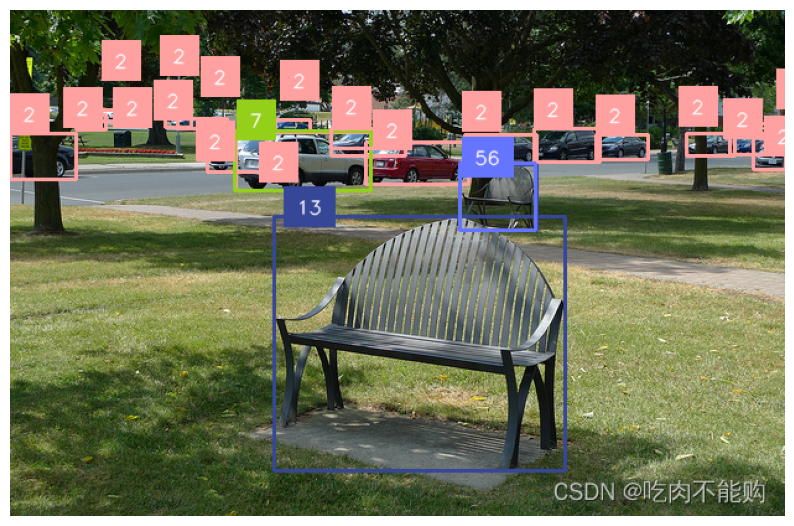

In [7]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(smart_position=True)
annotated_image = box_annotator.annotate(image.copy(), detections)
annotated_image = label_annotator.annotate(annotated_image, detections)
sv.plot_image(image=annotated_image, size=(10, 10))

In [8]:
torch.cuda.empty_cache()

Model configuration 

In [14]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CONFIG_PATH = config_file
WEIGHTS_PATH = checkpoint_file

In [10]:
model = init_detector(CONFIG_PATH, WEIGHTS_PATH, device=DEVICE)

Loads checkpoint by local backend from path: rtmdet_l_8xb32-300e_coco_20220719_112030-5a0be7c4.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std



Dataset prepare

In [18]:
from roboflow import Roboflow

In [19]:
ROBOFLOW_API_KEY = ('pEbpvVmHCmE4sFlvI8Og')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("safemacsws").project("mppe-custom-set")
version = project.version(4)
dataset = version.download("coco-mmdetection")

loading Roboflow workspace...
loading Roboflow project...


Train

After 

In [13]:
BATCH_SIZE = 4
MAX_EPOCHS = 50

In [14]:
CUSTOM_CONFIG_PATH = f"{HOME}/mmyolo/configs/rtmdet/custom.py"

CUSTOM_CONFIG = f"""
_base_ = ['../_base_/default_runtime.py', '../_base_/det_p5_tta.py']

# ========================Frequently modified parameters======================
# -----data related-----
data_root = '{dataset.location}/'

train_ann_file = 'train/_annotations.coco.json'
train_data_prefix = 'train/'

val_ann_file = 'valid/_annotations.coco.json'
val_data_prefix = 'valid/'

class_name = {tuple(sorted(project.classes.keys()))}
num_classes = {len(project.classes)}

metainfo = dict(classes=class_name, palette=[(20, 220, 60)])

train_batch_size_per_gpu = {BATCH_SIZE}
# Worker to pre-fetch data for each single GPU during training
train_num_workers = 2 # was 4 in original config
# persistent_workers must be False if num_workers is 0.
persistent_workers = True

# -----train val related-----
# Base learning rate for optim_wrapper. Corresponding to 8xb16=64 bs
base_lr = 0.004
max_epochs = {MAX_EPOCHS}  # Maximum training epochs
# Change train_pipeline for final 20 epochs (stage 2)
num_epochs_stage2 = 20

model_test_cfg = dict(
    # The config of multi-label for multi-class prediction.
    multi_label=True,
    # The number of boxes before NMS
    nms_pre=30000,
    score_thr=0.001,  # Threshold to filter out boxes.
    nms=dict(type='nms', iou_threshold=0.65),  # NMS type and threshold
    max_per_img=30)  # Max number of detections of each image

# ========================Possible modified parameters========================
# -----data related-----
img_scale = (640, 640)  # width, height
# ratio range for random resize
random_resize_ratio_range = (0.1, 2.0)
# Cached images number in mosaic
mosaic_max_cached_images = 40
# Number of cached images in mixup
mixup_max_cached_images = 20
# Dataset type, this will be used to define the dataset
dataset_type = 'YOLOv5CocoDataset'
# Batch size of a single GPU during validation
val_batch_size_per_gpu = 32
# Worker to pre-fetch data for each single GPU during validation
val_num_workers = 10

# Config of batch shapes. Only on val.
batch_shapes_cfg = dict(
    type='BatchShapePolicy',
    batch_size=val_batch_size_per_gpu,
    img_size=img_scale[0],
    size_divisor=32,
    extra_pad_ratio=0.5)

# -----model related-----
# The scaling factor that controls the depth of the network structure
deepen_factor = 1.0
# The scaling factor that controls the width of the network structure
widen_factor = 1.0
# Strides of multi-scale prior box
strides = [8, 16, 32]

norm_cfg = dict(type='BN')  # Normalization config

# -----train val related-----
lr_start_factor = 1.0e-5
dsl_topk = 13  # Number of bbox selected in each level
loss_cls_weight = 1.0
loss_bbox_weight = 2.0
qfl_beta = 2.0  # beta of QualityFocalLoss
weight_decay = 0.05

# Save model checkpoint and validation intervals
save_checkpoint_intervals = 10
# validation intervals in stage 2
val_interval_stage2 = 1
# The maximum checkpoints to keep.
max_keep_ckpts = 3
# single-scale training is recommended to
# be turned on, which can speed up training.
env_cfg = dict(cudnn_benchmark=True)

# ===============================Unmodified in most cases====================
# https://mmengine.readthedocs.io/en/latest/api/visualization.html
_base_.visualizer.vis_backends = [
    dict(type='LocalVisBackend'), #
    dict(type='TensorboardVisBackend'),]

model = dict(
    type='YOLODetector',
    data_preprocessor=dict(
        type='YOLOv5DetDataPreprocessor',
        mean=[103.53, 116.28, 123.675],
        std=[57.375, 57.12, 58.395],
        bgr_to_rgb=False),
    backbone=dict(
        type='CSPNeXt',
        arch='P5',
        expand_ratio=0.5,
        deepen_factor=deepen_factor,
        widen_factor=widen_factor,
        channel_attention=True,
        norm_cfg=norm_cfg,
        act_cfg=dict(type='SiLU', inplace=True)),
    neck=dict(
        type='CSPNeXtPAFPN',
        deepen_factor=deepen_factor,
        widen_factor=widen_factor,
        in_channels=[256, 512, 1024],
        out_channels=256,
        num_csp_blocks=3,
        expand_ratio=0.5,
        norm_cfg=norm_cfg,
        act_cfg=dict(type='SiLU', inplace=True)),
    bbox_head=dict(
        type='RTMDetHead',
        head_module=dict(
            type='RTMDetSepBNHeadModule',
            num_classes=num_classes,
            in_channels=256,
            stacked_convs=2,
            feat_channels=256,
            norm_cfg=norm_cfg,
            act_cfg=dict(type='SiLU', inplace=True),
            share_conv=True,
            pred_kernel_size=1,
            featmap_strides=strides),
        prior_generator=dict(
            type='mmdet.MlvlPointGenerator', offset=0, strides=strides),
        bbox_coder=dict(type='DistancePointBBoxCoder'),
        loss_cls=dict(
            type='mmdet.QualityFocalLoss',
            use_sigmoid=True,
            beta=qfl_beta,
            loss_weight=loss_cls_weight),
        loss_bbox=dict(type='mmdet.GIoULoss', loss_weight=loss_bbox_weight)),
    train_cfg=dict(
        assigner=dict(
            type='BatchDynamicSoftLabelAssigner',
            num_classes=num_classes,
            topk=dsl_topk,
            iou_calculator=dict(type='mmdet.BboxOverlaps2D')),
        allowed_border=-1,
        pos_weight=-1,
        debug=False),
    test_cfg=model_test_cfg,
)

train_pipeline = [
    dict(type='LoadImageFromFile', backend_args=_base_.backend_args),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='Mosaic',
        img_scale=img_scale,
        use_cached=True,
        max_cached_images=mosaic_max_cached_images,
        pad_val=114.0),
    dict(
        type='mmdet.RandomResize',
        # img_scale is (width, height)
        scale=(img_scale[0] * 2, img_scale[1] * 2),
        ratio_range=random_resize_ratio_range,
        resize_type='mmdet.Resize',
        keep_ratio=True),
    dict(type='mmdet.RandomCrop', crop_size=img_scale),
    dict(type='mmdet.YOLOXHSVRandomAug'),
    dict(type='mmdet.RandomFlip', prob=0.5),
    dict(type='mmdet.Pad', size=img_scale, pad_val=dict(img=(114, 114, 114))),
    dict(
        type='YOLOv5MixUp',
        use_cached=True,
        max_cached_images=mixup_max_cached_images),
    dict(type='mmdet.PackDetInputs')
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=_base_.backend_args),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='mmdet.RandomResize',
        scale=img_scale,
        ratio_range=random_resize_ratio_range,
        resize_type='mmdet.Resize',
        keep_ratio=True),
    dict(type='mmdet.RandomCrop', crop_size=img_scale),
    dict(type='mmdet.YOLOXHSVRandomAug'),
    dict(type='mmdet.RandomFlip', prob=0.5),
    dict(type='mmdet.Pad', size=img_scale, pad_val=dict(img=(114, 114, 114))),
    dict(type='mmdet.PackDetInputs')
]

test_pipeline = [
    dict(type='LoadImageFromFile', backend_args=_base_.backend_args),
    dict(type='YOLOv5KeepRatioResize', scale=img_scale),
    dict(
        type='LetterResize',
        scale=img_scale,
        allow_scale_up=False,
        pad_val=dict(img=114)),
    dict(type='LoadAnnotations', with_bbox=True, _scope_='mmdet'),
    dict(
        type='mmdet.PackDetInputs',
        meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape',
                   'scale_factor', 'pad_param'))
]

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    persistent_workers=persistent_workers,
    pin_memory=True,
    collate_fn=dict(type='yolov5_collate'),
    sampler=dict(type='DefaultSampler', shuffle=True),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        metainfo=metainfo,
        ann_file=train_ann_file,
        data_prefix=dict(img=train_data_prefix),
        filter_cfg=dict(filter_empty_gt=True, min_size=32),
        pipeline=train_pipeline))

val_dataloader = dict(
    batch_size=val_batch_size_per_gpu,
    num_workers=val_num_workers,
    persistent_workers=persistent_workers,
    pin_memory=True,
    drop_last=False,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        metainfo=metainfo,
        ann_file=val_ann_file,
        data_prefix=dict(img=val_data_prefix),
        test_mode=True,
        batch_shapes_cfg=batch_shapes_cfg,
        pipeline=test_pipeline))

test_dataloader = val_dataloader

# Reduce evaluation time
val_evaluator = dict(
    type='mmdet.CocoMetric',
    proposal_nums=(100, 1, 10),
    ann_file=data_root + val_ann_file,
    metric='bbox')
test_evaluator = val_evaluator

# optimizer
optim_wrapper = dict(
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=weight_decay),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=lr_start_factor,
        by_epoch=False,
        begin=0,
        end=1000),
    dict(
        # use cosine lr from 150 to 300 epoch
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

# hooks
default_hooks = dict(
    checkpoint=dict(
        type='CheckpointHook',
        interval=save_checkpoint_intervals,
        max_keep_ckpts=max_keep_ckpts  # only keep latest 3 checkpoints
    ))

custom_hooks = [
    dict(
        type='EMAHook',
        ema_type='ExpMomentumEMA',
        momentum=0.0002,
        update_buffers=True,
        strict_load=False,
        priority=49),
    dict(
        type='mmdet.PipelineSwitchHook',
        switch_epoch=max_epochs - num_epochs_stage2,
        switch_pipeline=train_pipeline_stage2)
]

train_cfg = dict(
    type='EpochBasedTrainLoop',
    max_epochs=max_epochs,
    val_interval=save_checkpoint_intervals,
    dynamic_intervals=[(max_epochs - num_epochs_stage2, val_interval_stage2)])

val_cfg = dict(type='ValLoop')
test_cfg = dict(type='TestLoop')
"""

In [15]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [16]:
%ls mmyolo/configs/rtmdet

README.md*
cspnext_imagenet_pretrain/
custom.py*
distillation/
metafile.yml*
rotated/
rtmdet-ins_s_syncbn_fast_8xb32-300e_coco.py*
rtmdet_l_syncbn_fast_8xb32-300e_coco.py*
rtmdet_m_syncbn_fast_8xb32-300e_coco.py*
rtmdet_s_syncbn_fast_8xb32-300e_coco.py*
rtmdet_tiny_fast_1xb12-40e_cat.py*
rtmdet_tiny_syncbn_fast_8xb32-300e_coco.py*
rtmdet_x_syncbn_fast_8xb32-300e_coco.py*


To train your model on newer verions of mmcv lib, you will need to:
* go to file ```./mmyolo/mmyolo/__init__.py```
* edit ```mmcv_maximum_version``` on line 10 to value '2.2.0'

If you can't access files from mmyolo, remove the corresponding line from gitignore


167 min 17 sec on 50 epoch train (RTX 4070TI)

In [17]:
%cd {HOME}/mmyolo
!python tools/train.py configs/rtmdet/custom.py

/mnt/d/Work/coding/vuzz/new/MIREA_7_semester_VT/rsppr/SAFE-MACS/model/rtmdet/mmyolo
/home/user/miniconda3/envs/mmyolo/lib/python3.11/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
05/26 17:45:37 - mmengine - WARNING - Failed to search registry with scope "mmyolo" in the "log_processor" registry tree. As a workaround, the current "log_processor" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmyolo" is a correct scope, or whether the registry is initialized.
05/26 17:45:38 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.11 (main, Dec 11 2024, 16:28:39) [GCC 11.2.0]
    

Load fine-tunned model

In [ ]:
CUSTOM_WEIGHTS_PATH = f"/content/mmyolo/work_dirs/custom/epoch_{MAX_EPOCHS}.pth"

In [15]:
CUSTOM_WEIGHTS_PATH = f"/content/mmyolo/work_dirs/custom/epoch_50.pth"
CUSTOM_CONFIG_PATH = f"{HOME}/mmyolo/configs/rtmdet/custom.py"

In [11]:
%ls mmyolo/work_dirs/custom

20250526_174537/  epoch_30.pth*  epoch_50.pth*
custom.py*        epoch_40.pth*  last_checkpoint*


In [16]:
model = init_detector(CUSTOM_CONFIG_PATH, './mmyolo/work_dirs/custom/epoch_50.pth', device=DEVICE)
# model/rtmdet/mmyolo/work_dirs/custom/epoch_50.pth

Loads checkpoint by local backend from path: ./mmyolo/work_dirs/custom/epoch_50.pth


In [20]:
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

images = list(ds.images.values())

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.


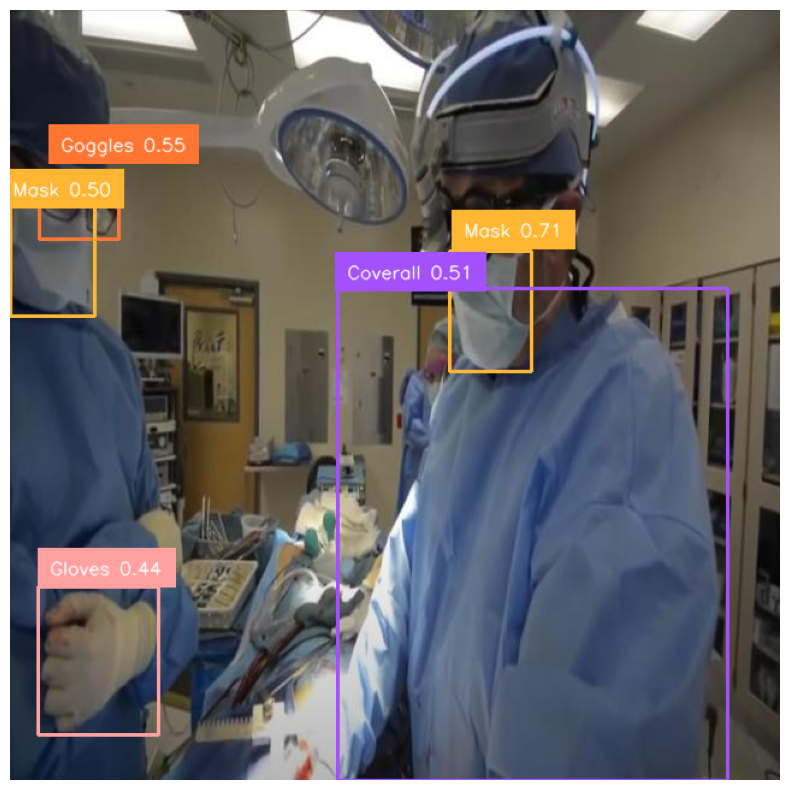

In [35]:
image = random.choice(images)
result = inference_detector(model, image)
detections = sv.Detections.from_mmdetection(result)
detections = detections[detections.confidence > 0.4].with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(smart_position=True)
detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]
annotated_image = box_annotator.annotate(image.copy(), detections)
annotated_image = label_annotator.annotate(annotated_image, detections, detections_labels)
sv.plot_image(image=annotated_image, size=(10, 10))

Evaluation

In [23]:
from supervision.metrics import F1Score, Precision, Recall

In [30]:
CONFIDENCE_THRESHOLD = 0.35
NMS_IOU_THRESHOLD = 0.7

In [31]:
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

print('dataset classes:', ds.classes)
print('dataset size:', len(ds))

dataset classes: ['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask']
dataset size: 287


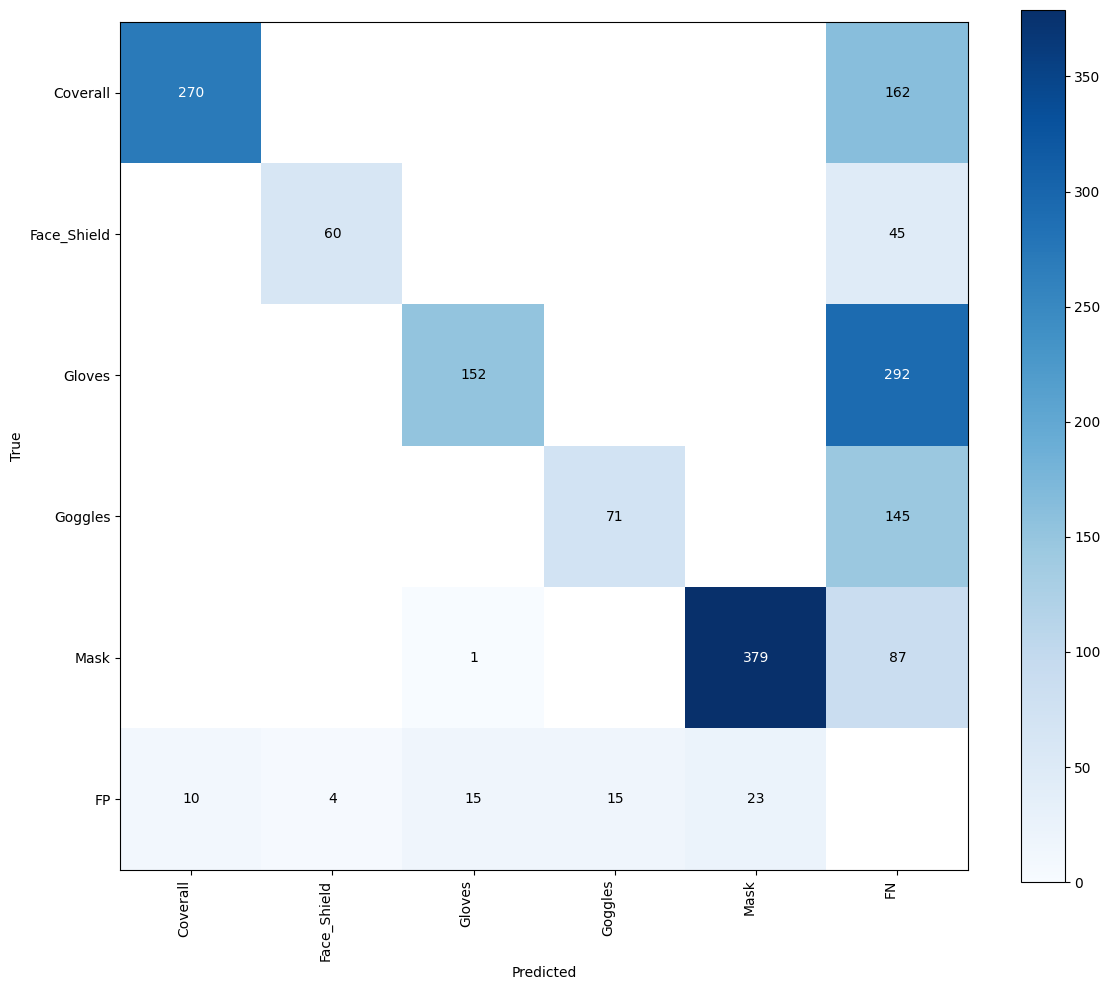

In [33]:
def callback(image: np.ndarray) -> sv.Detections:
    result = inference_detector(model, image)
    detections = sv.Detections.from_mmdetection(result)
    return detections[detections.confidence > CONFIDENCE_THRESHOLD].with_nms(threshold=NMS_IOU_THRESHOLD)


confusion_matrix = sv.ConfusionMatrix.benchmark(
    dataset = ds,
    callback = callback
)

_ = confusion_matrix.plot()

In [37]:
mean_average_precision = sv.MeanAveragePrecision.benchmark(
    dataset = ds,
    callback = callback
)

print(f"map50_95: {mean_average_precision.map50_95:.3f}")
print(f"map50: {mean_average_precision.map50:.3f}")
print(f"map75: {mean_average_precision.map75:.3f}")

map50_95: 0.507
map50: 0.735
map75: 0.564


In [39]:
per_class_map = mean_average_precision.per_class_ap50_95.mean(axis=1)
for class_name, value in zip(ds.classes, per_class_map):
    print(f"{class_name}: {value:.3f}")

Coverall: 0.643
Face_Shield: 0.518
Gloves: 0.427
Goggles: 0.286
Mask: 0.659


In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import F1Score, Precision, Recall

In [45]:
targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    result = inference_detector(model, image)
    detections = sv.Detections.from_mmdetection(result)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 287/287 [00:11<00:00, 24.31it/s]


In [48]:
precision_metric = Precision().update(predictions, targets).compute()
recall_metric = Recall().update(predictions, targets).compute()
f1_metric = F1Score().update(predictions, targets).compute()

print(f"Precision: {precision_metric.precision_at_50:.3f}")
print(f"Recall: {recall_metric.recall_at_50:.3f}")
print(f"F1 Score: {f1_metric.f1_50:.3f}")

Precision: 0.197
Recall: 0.873
F1 Score: 0.319


In [49]:
print(f"F1 Score: {f1_metric.f1_scores} at\nIoU thresholds: {f1_metric.iou_thresholds}")

F1 Score: [0.31927598 0.311299   0.30415168 0.29100588 0.274761   0.24581475
 0.20677717 0.15232467 0.08304344 0.01819359] at
IoU thresholds: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
